In [1]:
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from PIL import Image
import matplotlib.pyplot as plt
from src.wards_data import WardDataset

In [2]:
load_dotenv()

STRATZ_TOKEN = os.getenv('STRATZ_TOKEN')
if not STRATZ_TOKEN:
    raise FileNotFoundError("Not found STRATZ_TOKEN on .env")

ward_dataset = WardDataset(STRATZ_TOKEN)

In [3]:
df_data = ward_dataset.get_by_time_merged_dataset()
df_data

time               id       match  positionX  positionY  wardType  \
0         -2   7811671022_450  7811671022         38         36  OBSERVER   
1         -1   7811671022_450  7811671022         38         36  OBSERVER   
2          0   7811671022_450  7811671022         38         36  OBSERVER   
3          1   7811671022_450  7811671022         38         36  OBSERVER   
4          2   7811671022_450  7811671022         38         36  OBSERVER   
...      ...              ...         ...        ...        ...       ...   
216060    40  7797229046_3179  7797229046         50         34    SENTRY   
216061    39  7797229046_2358  7797229046         24         10    SENTRY   
216062    40  7797229046_2358  7797229046         24         10    SENTRY   
216063    40  7797229046_2245  7797229046         19         19  OBSERVER   
216064    40  7797229046_2591  7797229046         19         19    SENTRY   

        isRadiant playerDestroyed  didRadiantWin     radiantTeam   direTeam  \
0            True            None           True  Tundra Esports  PSG.Quest   
1            True            None           True  Tundra Esports  PSG.Quest   
2            True            None           True  Tundra Esports  PSG.Quest   
3            True            None           True  Tundra Esports  PSG.Quest   
4            True            None           True  Tundra Esports  PSG.Quest   
...           ...             ...            ...             ...        ...   
216060      False            None          False            NEFU  КНИТУ-КАИ   
216061       True            None          False            NEFU  КНИТУ-КАИ   
216062       True            None          False            NEFU  КНИТУ-КАИ   
216063      False            None          False            NEFU  КНИТУ-КАИ   
216064      False            None          False            NEFU  КНИТУ-КАИ   

        league  region                                         leagueName  \
0        16842  EUROPE  Road To The International 2024  - Regional Qua...   
1        16842  EUROPE  Road To The International 2024  - Regional Qua...   
2        16842  EUROPE  Road To The International 2024  - Regional Qua...   
3        16842  EUROPE  Road To The International 2024  - Regional Qua...   
4        16842  EUROPE  Road To The International 2024  - Regional Qua...   
...        ...     ...                                                ...   
216060   16605     CIS    Всероссийская киберспортивная студенческая лига   
216061   16605     CIS    Всероссийская киберспортивная студенческая лига   
216062   16605     CIS    Всероссийская киберспортивная студенческая лига   
216063   16605     CIS    Всероссийская киберспортивная студенческая лига   
216064   16605     CIS    Всероссийская киберспортивная студенческая лига   

        didWardWin  
0             True  
1             True  
2             True  
3             True  
4             True  
...            ...  
216060        True  
216061       False  
216062       False  
216063        True  
216064        True  

[216065 rows x 15 columns]

In [4]:
len(df_data['match'].unique())

526

In [5]:
df_data['leagueName'].unique()

array(['Road To The International 2024  - Regional Qualifiers Western Europe',
       'Road To The International 2024  - Regional Qualifiers Southeast Asia',
       'Road To The International 2024  - Regional Qualifiers South America',
       'Road To The International 2024 - Regional Qualifiers Eastern Europe',
       'Road To The International 2024 - Regional Qualifiers China',
       'Road To The International 2024  - Regional Qualifiers North America',
       'Elite League Season 2 EEU Closed Qualifiers – presented by ESB',
       'Elite League Season 2 WEU Closed Qualifiers – presented by ESB',
       'Elite League Season 2 SA Closed Qualifiers – presented by ESB',
       'Elite League Season 2 NA Closed Qualifiers – presented by ESB',
       'Elite League Season 2 CN Closed Qualifiers – presented by ESB',
       'Elite League Season 2 SEA Closed Qualifiers – presented by ESB',
       'Illuminational Dota 2 Challenger #2',
       'IESF Asia and Oceania Regional Qualifier 2024',
  

In [6]:
BG_MAP_SIZE = np.array((5000, 5000))

Text(0.5, 1.0, 'Most extreme coordinates wards')

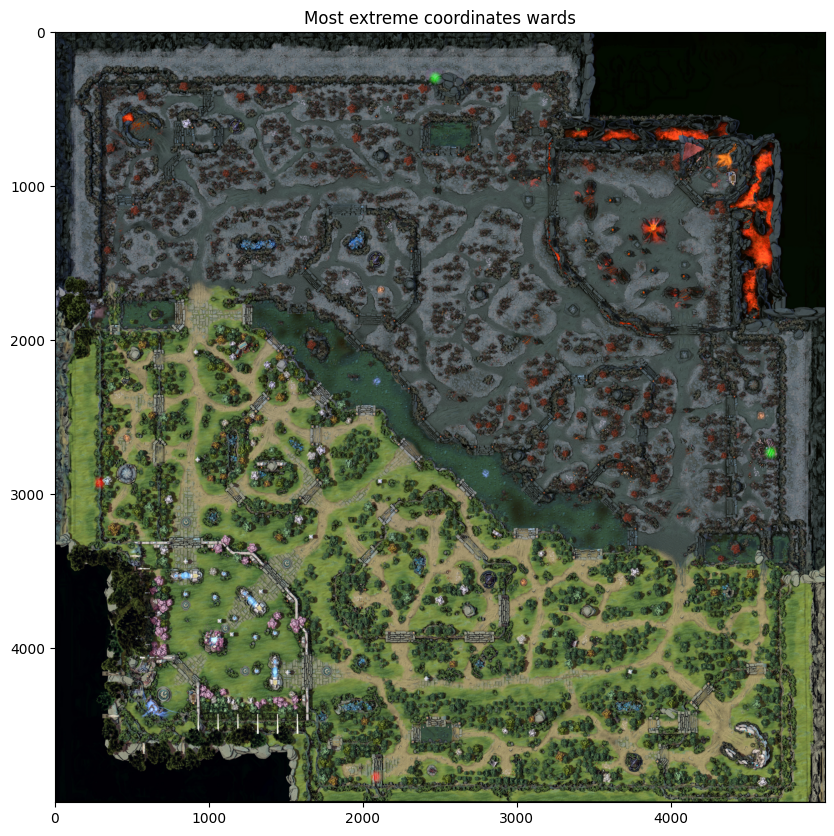

In [7]:

import matplotlib.patches as mpatches
map_size = (df_data['positionY'].max()+5, df_data['positionX'].max()+5)
def wards_hotmap(df: pd.DataFrame):
    
    # load bg_map
    bg_map = np.array(Image.open('assets\Game_map_7.33.webp').resize(BG_MAP_SIZE))

    positionX = df['positionX']
    positionY = df['positionY']
    isRadiant = df['isRadiant']
    didWardWin = df['didWardWin']
    
    
    map = np.zeros((map_size[0], map_size[1], 3))

    for px, py, is_radiant, did_ward_win in zip(positionX, positionY, isRadiant, didWardWin):
        color_channels = (False,True,False) if is_radiant else (True,False,False)
        # print(map[py, px, color_channels])
        map[py, px, color_channels] += 1 # if did_ward_win else -1
    map = np.clip(map * 1., a_min=0, a_max=float("+inf"))
    #map[:,:,0] = (map[:,:,0] * 255.) // map[:,:,0].max()
    #map[:,:,1] = (map[:,:,1] * 255.) // map[:,:,1].max()
    #map[:,:,2] = (map[:,:,2] * 255.) // map[:,:,2].max()
    map = (map * 255) // map.max()
    map = np.flip(map, axis=0)
    map_to_pil = map.astype(np.uint8)
    map = np.array(Image.fromarray(map_to_pil).resize(BG_MAP_SIZE, resample=Image.Resampling.LANCZOS))
    map = np.clip(map * 1., a_min=0, a_max=230)
    
    map_alpha = map / 255

    merged_map = map * map_alpha + bg_map * (1 - map_alpha)
    merged_map = np.array(merged_map, dtype=np.uint8)

    return merged_map

mask = df_data['wardType'] == "OBSERVER"

df_observer = df_data[mask].reset_index()

sample = pd.concat([
    df_observer.iloc[df_observer['positionX'].idxmax()].to_frame().T,
    df_observer.iloc[df_observer['positionX'].idxmin()].to_frame().T,
    df_observer.iloc[df_observer['positionY'].idxmax()].to_frame().T,
    df_observer.iloc[df_observer['positionY'].idxmin()].to_frame().T,
])

plt.figure(figsize=(10,10))
plt.imshow(wards_hotmap(sample))
plt.title("Most extreme coordinates wards")

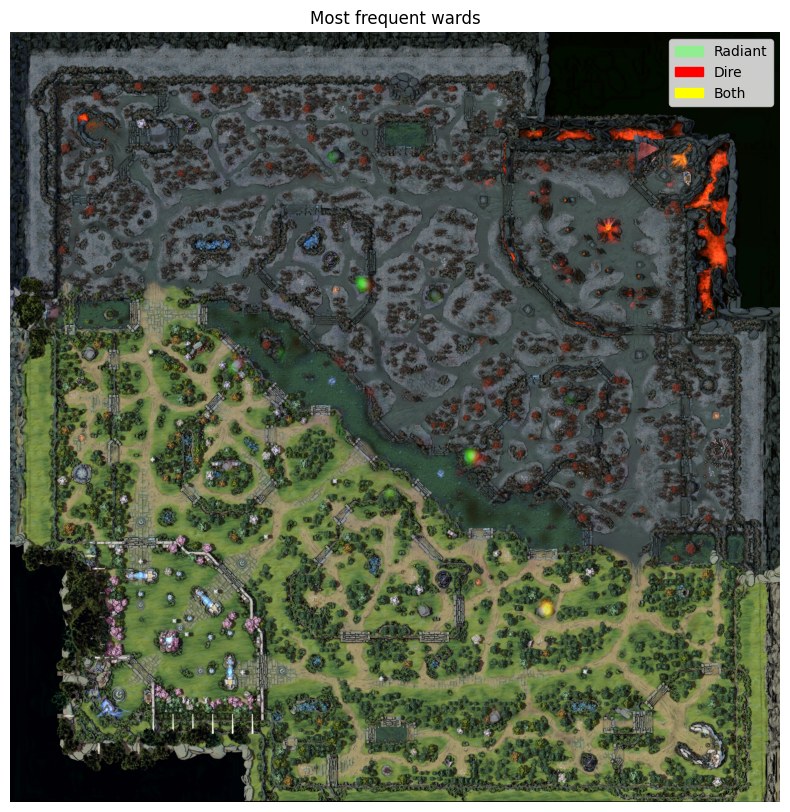

In [8]:
plt.figure(figsize=(10,10), dpi=100)
plt.axis('off')
plt.title("Most frequent wards")

# Create custom legend patches
legend_patches = [
    mpatches.Patch(color='#90ee90', label='Radiant'),
    mpatches.Patch(color='red', label='Dire'),
    mpatches.Patch(color='yellow', label='Both')
]

# Add legend to the plot
plt.legend(handles=legend_patches, loc='upper right')

plt.imshow(wards_hotmap(df_observer))
plt.show()

<Axes: ylabel='Frequency'>

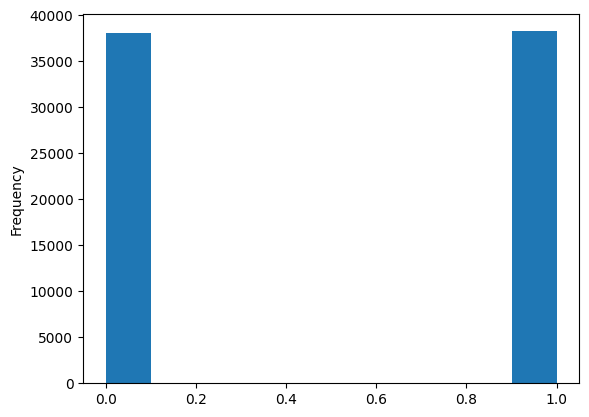

In [9]:
df_observer['isRadiant'].astype(int).plot(kind='hist')

In [10]:
# df_observer['score'] = df_observer['didWardWin'].map(lambda x: 1 if x == True else 0)
grouped_score = df_observer.groupby(['positionX', 'positionY', 'isRadiant'])['didWardWin']
df_scores = grouped_score.count().reset_index(name="wardCount")
df_scores['wins'] = grouped_score.sum().reset_index()['didWardWin']
# df_scores = grouped_score.sum().to_frame()
# df_scores = df_scores.reset_index()
# df_scores[['wards_count']].plot(kind='hist', bins=12, alpha=0.5)
df_scores['winRate'] = df_scores['wins'] /  df_scores['wardCount']
df_scores

positionX  positionY  isRadiant  wardCount  wins  winRate
0             4         31      False          1     1      1.0
1             5         36       True          6     0      0.0
2             5         39      False          6     6      1.0
3             5         53       True          6     0      0.0
4             6         29       True          7     0      0.0
...         ...        ...        ...        ...   ...      ...
2743         72         34       True          2     2      1.0
2744         72         35       True          2     2      1.0
2745         72         36       True          6     0      0.0
2746         72         37      False          4     0      0.0
2747         72         37       True          6     6      1.0

[2748 rows x 6 columns]

<Axes: title={'center': 'Winrate distribution before mask'}, ylabel='Frequency'>

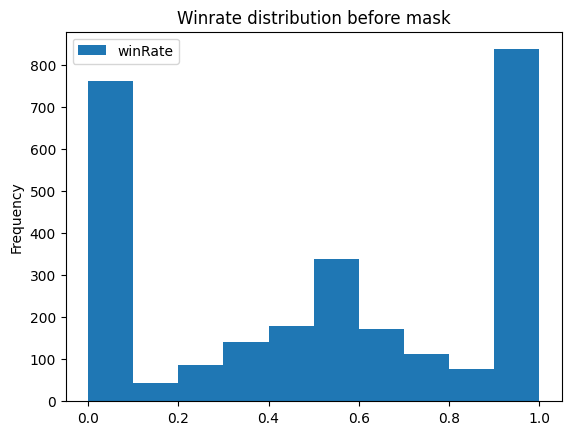

In [11]:
df_scores[['winRate']].plot(kind='hist', title="Winrate distribution before mask")

<Axes: title={'center': 'Winrate distribution after mask'}, ylabel='Frequency'>

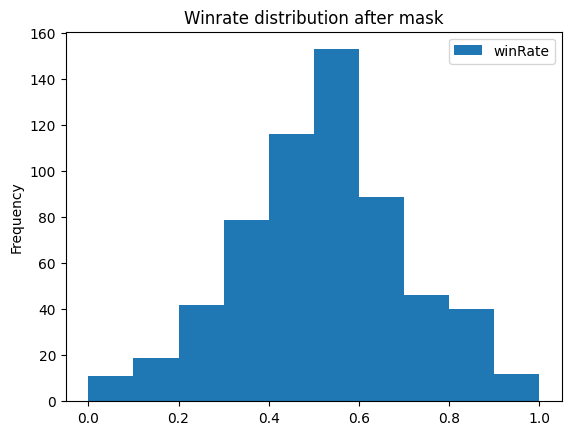

In [12]:
mask = df_scores['wardCount'] > df_scores['wardCount'].mean()
df_scores_masked = df_scores[mask]
df_scores_masked[['winRate']].plot(kind='hist', title="Winrate distribution after mask")

<Axes: title={'center': 'wardCount / max(wardCount)'}, ylabel='Frequency'>

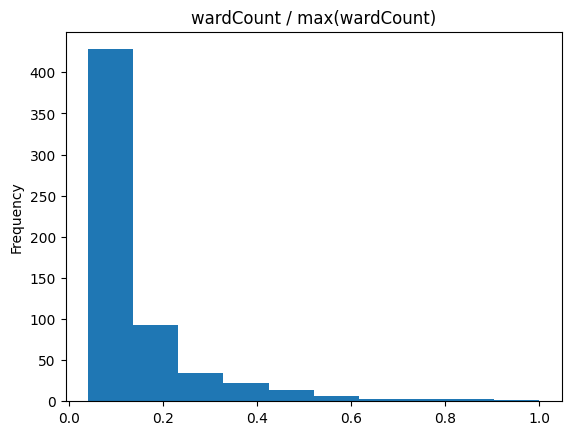

In [13]:
(df_scores_masked['wardCount'] / df_scores_masked['wardCount'].max()).plot(kind='hist', title="wardCount / max(wardCount)")

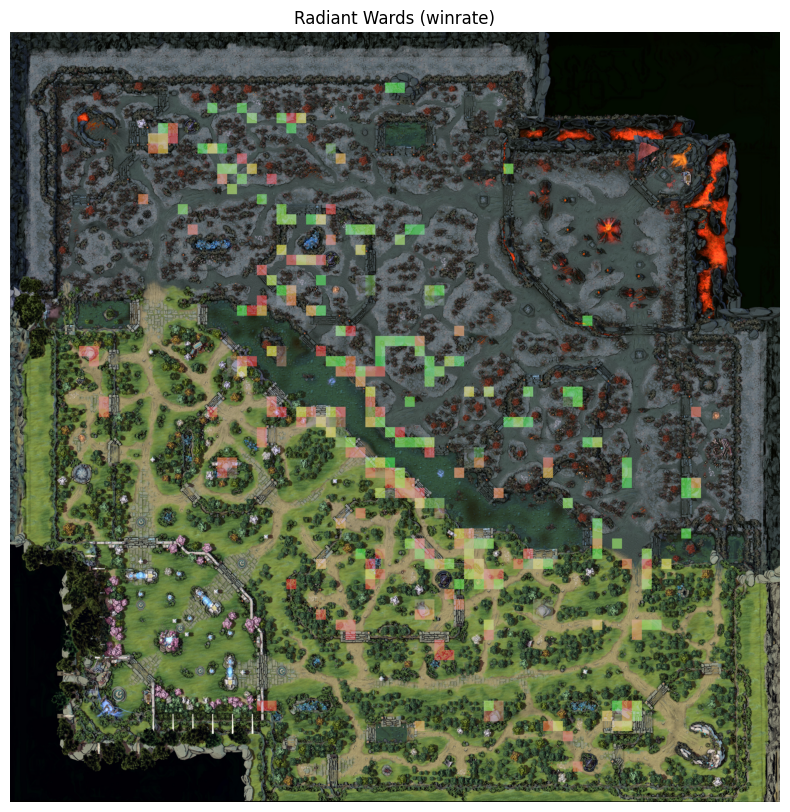

In [14]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

def rescale_pixel(map, factor=1, limit=255):
    max_value = np.max(map, axis=2)
    mask = max_value > 0
    max_factor = np.zeros_like(max_value)
    max_factor[mask] = limit / max_value[mask]
    curr_factor = max_factor
    curr_factor_mask = factor < max_factor
    curr_factor[curr_factor_mask] = factor
    return map * curr_factor[:, :, np.newaxis] 

def wards_hotmap_winrate(df: pd.DataFrame):
    
    # load bg_map
    bg_map = np.array(Image.open('assets\Game_map_7.33.webp').resize(BG_MAP_SIZE).convert('RGBA'))

    positionX = df['positionX']
    positionY = df['positionY']
    winRate = df['winRate']
    wardCount = df['wardCount']
    
    # get blank arr map
    
    map = np.zeros((map_size[0], map_size[1], 4))

    for px, py, win_rate, ward_count in zip(positionX, positionY, winRate, wardCount):
        red = (1 - win_rate) * 255
        green = win_rate * 255
        alpha = ward_count
        blue = 0
        map[py, px] = (red, green, blue, alpha)
    map = np.clip(map * 1., a_min=0, a_max=float("+inf"))
    map = (map * 255) // map.max()
    map = np.flip(map, axis=0)
    map = rescale_pixel(map, 50, 195)
    
    map_to_pil = map.astype(np.uint8)
    map = np.array(Image.fromarray(map_to_pil, 'RGBA').resize(BG_MAP_SIZE, resample=Image.Resampling.NEAREST))
    # map = np.clip(map * 1., a_min=0, a_max=195)
    map_alpha = map / 255

    merged_map = map * map_alpha + bg_map * (1 - map_alpha)
    merged_map = np.array(merged_map, dtype=np.uint8)

    return merged_map

# radiant
plt.figure(figsize=(10,10), dpi=100)
plt.axis('off')
plt.title("Radiant Wards (winrate)")
plt.imshow(wards_hotmap_winrate(df_scores_masked[df_scores_masked['isRadiant'] == True]))

# dire
plt.figure(figsize=(10,10), dpi=100)
plt.axis('off')
plt.title("Dire Wards (winrate)")
plt.imshow(wards_hotmap_winrate(df_scores_masked[df_scores_masked['isRadiant'] == False]))

In [15]:
df_scores.sort_values("wardCount", ascending=False)

positionX  positionY  isRadiant  wardCount  wins   winRate
2219         54         19      False        683   319  0.467057
1295         35         51       True        588   277  0.471088
1871         46         34       True        578   354  0.612457
2217         54         18      False        570   322  0.564912
2218         54         18       True        550   312  0.567273
...         ...        ...        ...        ...   ...       ...
896          28         56      False          1     1  1.000000
865          28         13      False          1     1  1.000000
2361         58         53       True          1     1  1.000000
773          26         32       True          1     0  0.000000
0             4         31      False          1     1  1.000000

[2748 rows x 6 columns]

## tensor

In [16]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [17]:
torch.tensor

<function torch._VariableFunctionsClass.tensor>